In [1]:
#!/home/siervod/anaconda3/envs/eqcc/bin/python
"""
Author: Daniel Siervo, emetdan@gmail.com
Date: 2024-11-12
"""
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# EDA

## Feature Engineering

In [2]:
# Load the data from both files and add a "type" column to distinguish between real and fake
real_df = pd.read_csv('all_real_picks.csv')
real_df['type'] = 1  # 1 for real data

fake_df = pd.read_csv('all_fake_picks.csv')
fake_df['type'] = 0  # 0 for fake data

# Combine the real and fake data into a single DataFrame
df = pd.concat([real_df, fake_df], ignore_index=True)

# Replace "no pick" entries with NaN for easier processing
df['s_t'].replace('no pick', pd.NA, inplace=True)
df['s_prob'].replace('no pick', pd.NA, inplace=True)

# Convert probabilities to numeric to avoid issues with NaN in calculations
df['p_prob'] = pd.to_numeric(df['p_prob'], errors='coerce')
df['s_prob'] = pd.to_numeric(df['s_prob'], errors='coerce')

# Group by event_id and type to compute the required statistics
result = df.groupby(['event_id', 'type']).agg(
    p_n=('station', 'count'),
    s_n=('s_t', lambda x: x.notna().sum()),
    sp_ratio=('s_t', lambda x: x.notna().sum() / x.size),
    p_prob_av=('p_prob', 'mean'),
    s_prob_av=('s_prob', 'mean'),
    p_prob_st=('p_prob', 'std'),
    s_prob_st=('s_prob', 'std'),
    p_prob_max=('p_prob', 'max'),
    s_prob_max=('s_prob', 'max'),
    p_prob_min=('p_prob', 'min'),
    s_prob_min=('s_prob', 'min')
).reset_index()

# Save to a new CSV file
result.to_csv('combined_output_clean_test1.csv', index=False)


## Statistical Analysis

### T-Test

Allows to check if there is a significant difference between 2 means.
So, here we can check how important is a feature for the classification model.

In [3]:
from scipy.stats import ttest_ind

# Load the combined dataset
# df = pd.read_csv('combined_output.csv')
df = pd.read_csv('combined_output_clean_test1.csv')

# Separate real and fake data for comparison
real_data = df[df['type'] == 1]
fake_data = df[df['type'] == 0]

# Initialize a results dictionary to store the comparisons
comparisons = {}

# Compare each feature of interest between real and fake data
features = ['p_n', 's_n', 'sp_ratio', 'p_prob_av', 's_prob_av', 'p_prob_st', 
            's_prob_st', 'p_prob_max', 's_prob_max', 'p_prob_min', 's_prob_min']

for feature in features:
    # Perform an independent t-test to compare means
    stat, p_value = ttest_ind(real_data[feature].dropna(), fake_data[feature].dropna())
    comparisons[feature] = {'real_mean': real_data[feature].mean(),
                            'fake_mean': fake_data[feature].mean(),
                            'p_value': p_value}

# Convert the results into a DataFrame for easier viewing
comparison_df = pd.DataFrame(comparisons).T
print(comparison_df)


            real_mean  fake_mean        p_value
p_n         16.766169   4.604061   1.044958e-47
s_n         15.019900   1.096447   9.710408e-70
sp_ratio     0.912002   0.234445  1.496817e-136
p_prob_av    0.512683   0.118512  1.225150e-117
s_prob_av    0.672819   0.175156  1.539336e-116
p_prob_st    0.343046   0.151703   6.109390e-58
s_prob_st    0.197697   0.141210   3.981556e-06
p_prob_max   0.908080   0.339203  8.234124e-101
s_prob_max   0.869214   0.227359  6.253860e-140
p_prob_min   0.052030   0.010660   1.659480e-04
s_prob_min   0.259333   0.129781   1.586851e-08


### Histograms

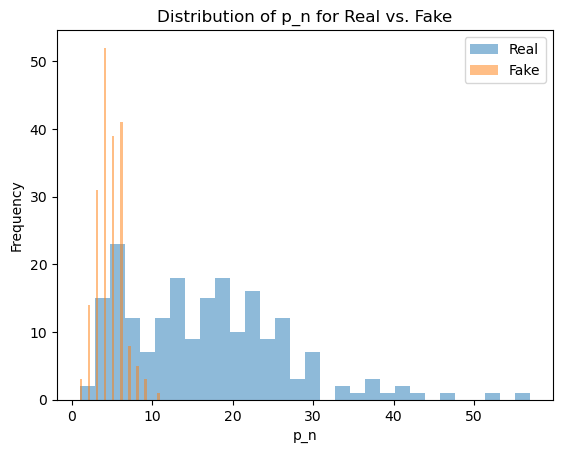

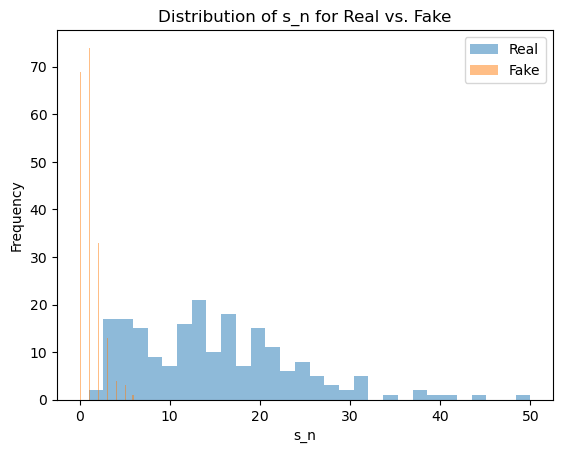

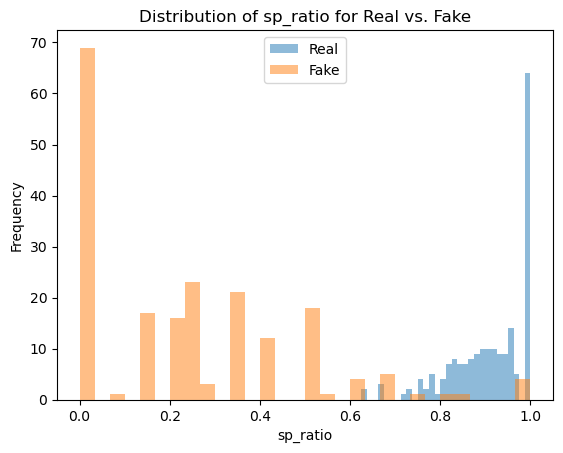

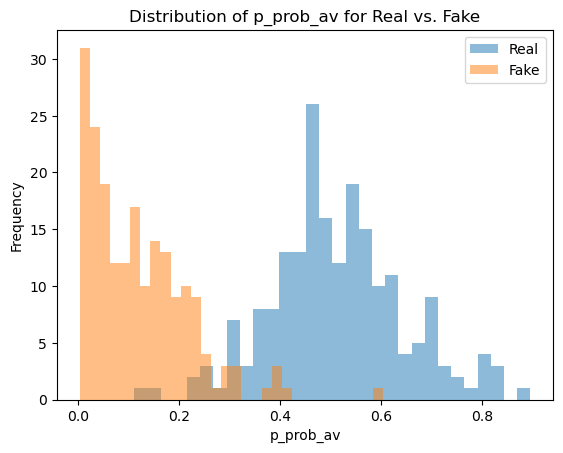

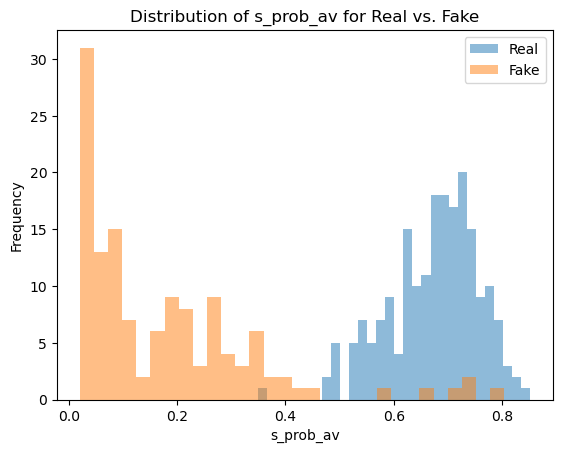

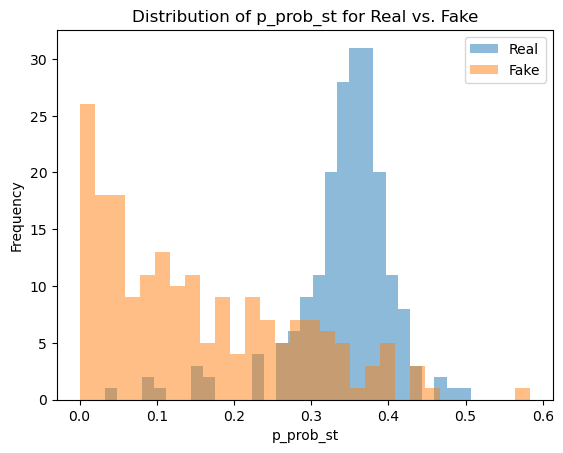

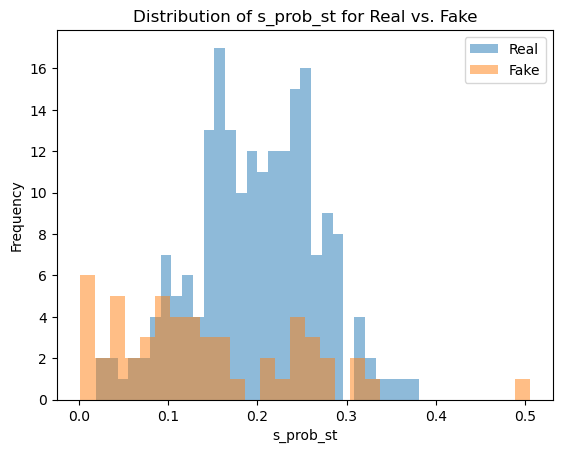

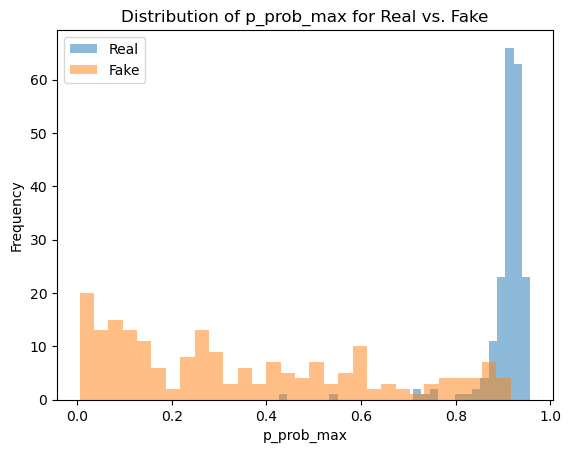

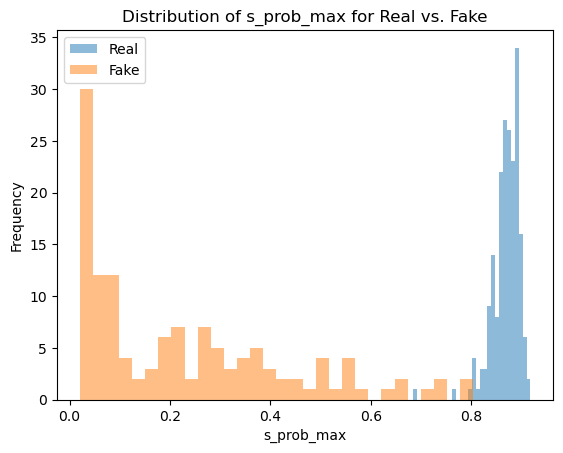

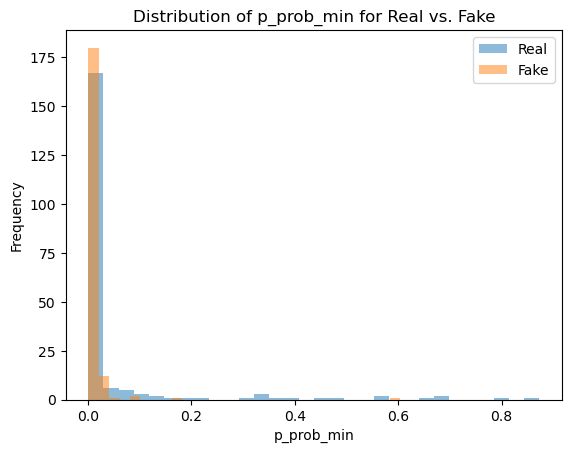

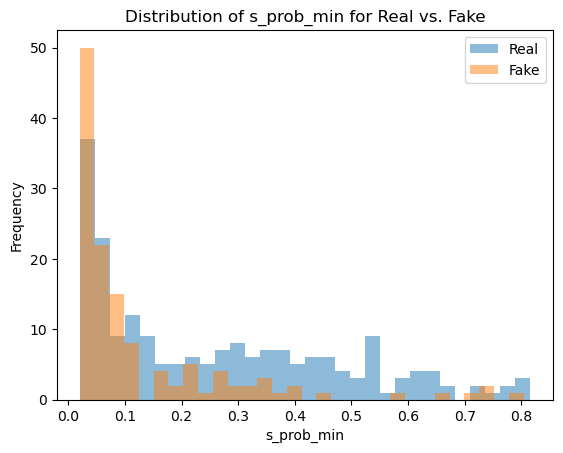

In [4]:
import matplotlib.pyplot as plt

# Plot histograms for each feature
for feature in features:
    plt.figure()
    plt.hist(real_data[feature].dropna(), bins=30, alpha=0.5, label='Real')
    plt.hist(fake_data[feature].dropna(), bins=30, alpha=0.5, label='Fake')
    plt.title(f'Distribution of {feature} for Real vs. Fake')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()


### Correlation Heatmap

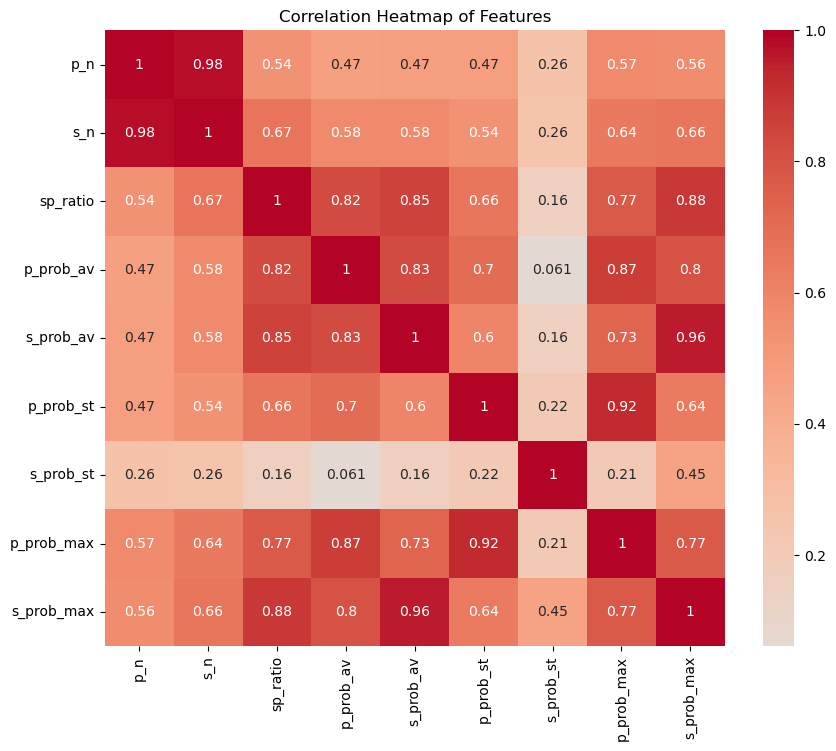

In [5]:
import seaborn as sns
plt.figure(figsize=(10, 8))
features = ['p_n', 's_n', 'sp_ratio', 'p_prob_av', 's_prob_av', 'p_prob_st', 
            's_prob_st', 'p_prob_max', 's_prob_max']
corr = df[features].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap of Features')
plt.show()

In [6]:
df.head()

,event_id,type,p_n,s_n,sp_ratio,p_prob_av,s_prob_av,p_prob_st,s_prob_st,p_prob_max,s_prob_max,p_prob_min,s_prob_min
0,texnet2024pche,1,37,35,0.945946,0.523459,0.627771,0.315028,0.247104,0.936,0.886,0.002,0.040
1,texnet2024pcil,1,16,15,0.937500,0.520125,0.700067,0.342856,0.257019,0.915,0.888,0.002,0.066
2,texnet2024pcle,1,5,4,0.800000,0.248800,0.648750,0.342235,0.196471,0.721,0.838,0.002,0.413
3,texnet2024pcng,1,14,12,0.857143,0.433286,0.636833,0.391302,0.278484,0.948,0.865,0.002,0.045
4,texnet2024pebf,1,18,17,0.944444,0.502167,0.759471,0.388544,0.168756,0.953,0.906,0.002,0.338


### Principal Component Analysis (PCA)

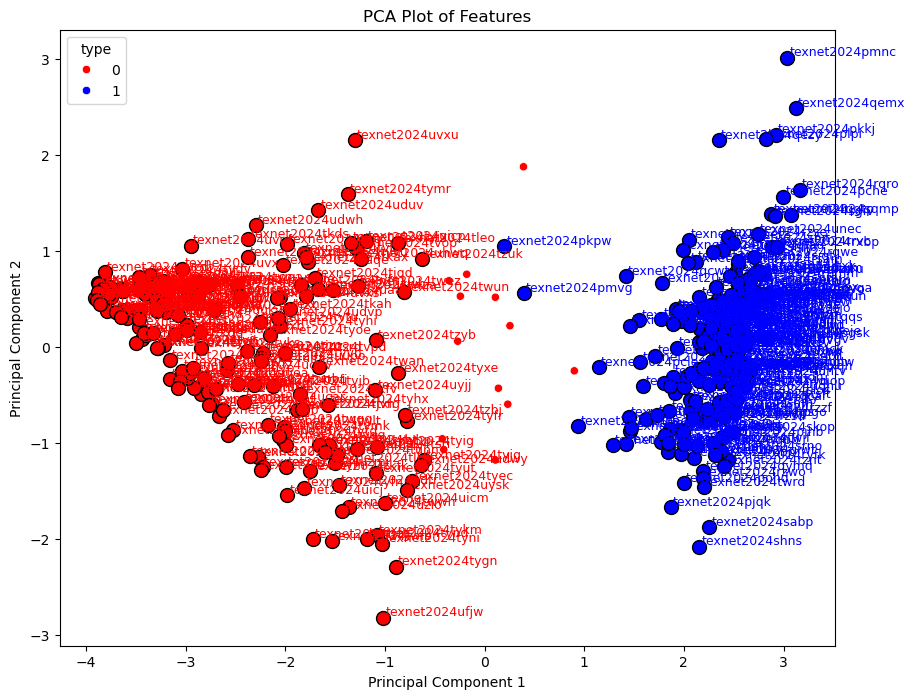

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Assuming df is already defined and contains 'event_id' column and the data

# Fill NaNs with 0
df.fillna(0, inplace=True)

# Select features and target
features = ['p_n', 'sp_ratio', 'p_prob_av', 's_prob_av', 'p_prob_st', 
            's_prob_st', 'p_prob_max', 's_prob_max']
X = df[features]  # Features for PCA
y = df['type']    # Target (real vs. fake)
event_ids = df['event_id']  # Event IDs to track

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform PCA for dimensionality reduction to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create a DataFrame for plotting
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['type'] = y
pca_df['event_id'] = event_ids

# Plotting all points with hue based on type
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='type', data=pca_df, palette=['red', 'blue'])
plt.title('PCA Plot of Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Filtering for red points (type 0) with PC1 > 0
red_points = pca_df[(pca_df['type'] == 0) & (pca_df['PC1'] < -0.5)]

# Filtering for blue points (type 1) with PC1 < 0
blue_points = pca_df[(pca_df['type'] == 1) & (pca_df['PC1'] > -0.5)]

# Plot and annotate red points with event_id
for _, row in red_points.iterrows():
    plt.scatter(row['PC1'], row['PC2'], color='red', edgecolor='black', s=100, marker='o')
    plt.text(row['PC1'] + 0.02, row['PC2'] + 0.02, str(row['event_id']), fontsize=9, color='red')

# Plot and annotate blue points with event_id
for _, row in blue_points.iterrows():
    plt.scatter(row['PC1'], row['PC2'], color='blue', edgecolor='black', s=100, marker='o')
    plt.text(row['PC1'] + 0.02, row['PC2'] + 0.02, str(row['event_id']), fontsize=9, color='blue')

plt.show()


# Random Forest classifier

Precision: 1.00
Recall: 1.00
F1 Score: 1.00


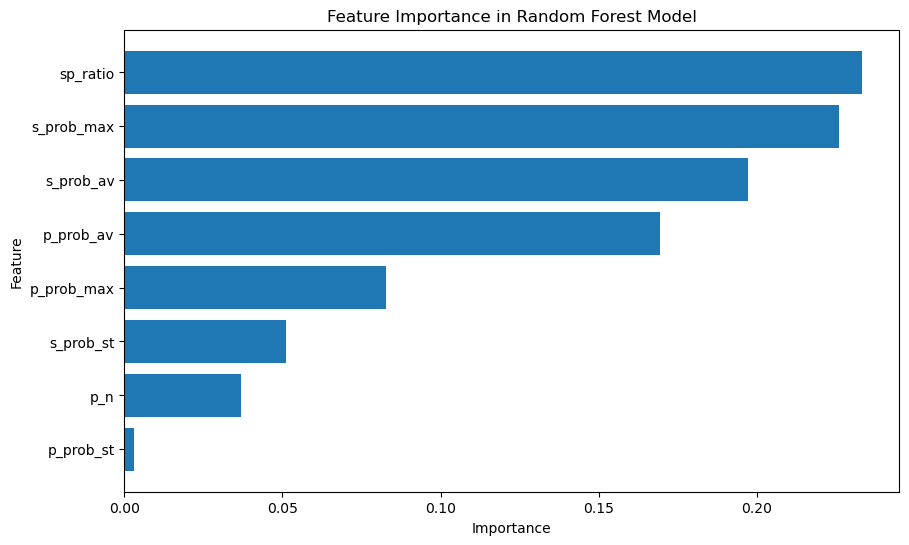

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the combined dataset
# df = pd.read_csv('combined_output.csv')
df = pd.read_csv('combined_output_clean_test1.csv')


df.fillna(0, inplace=True)

# Specify the features and the target variable
features = ['p_n', 'sp_ratio', 'p_prob_av', 's_prob_av', 'p_prob_st', 
            's_prob_st', 'p_prob_max', 's_prob_max']
X = df[features]
y = df['type']
X = X.replace([np.inf, -np.inf], np.nan).dropna()
y = y.replace([np.inf, -np.inf], np.nan).dropna()
# Standardize the features for better performance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Initialize and train the Random Forest model
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)

# Get feature importances from the model
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({'feature': features, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

# evaluate the model, get precision, recall, f1 score
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)

from sklearn.metrics import precision_score, recall_score, f1_score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['feature'], feature_importance_df['importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Random Forest Model')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


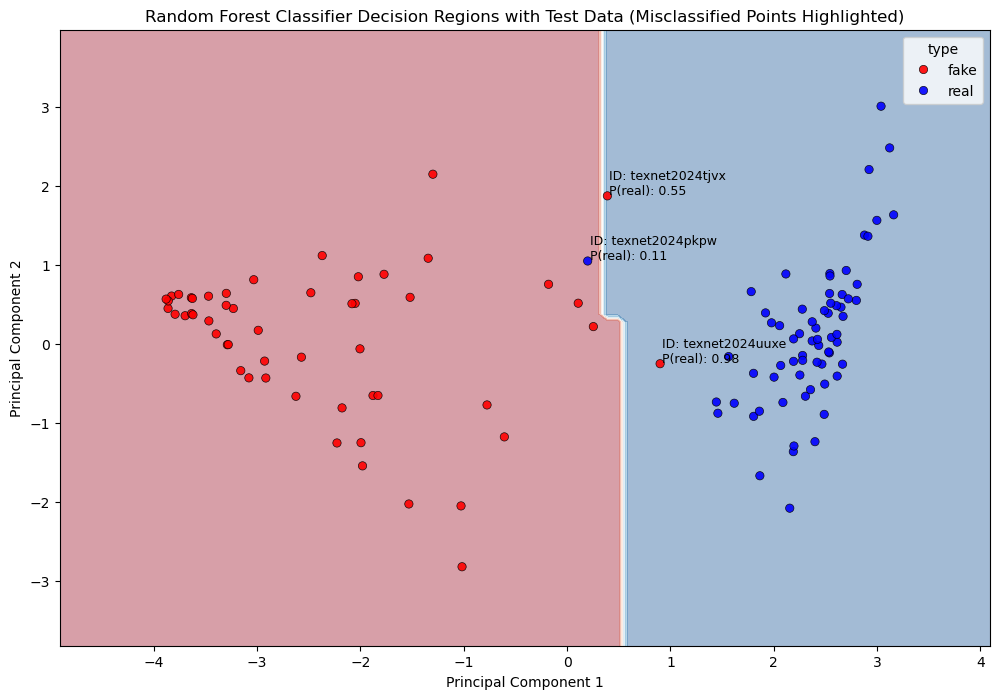

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns

# Load the combined dataset
# df = pd.read_csv('combined_output.csv')
df = pd.read_csv('combined_output_clean_test1.csv')
df.fillna(0, inplace=True)

# Specify the features and the target variable
X = df[features]
y = df['type']
event_ids = df['event_id']  # Store event_id to track points

# Remove NaNs and Infs
X = X.replace([np.inf, -np.inf], np.nan).dropna()
y = y.loc[X.index]  # Keep y in sync with X after dropping NaNs
event_ids = event_ids.loc[X.index]

# Standardize the features for better performance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reduce dimensions to 2 using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create a DataFrame for easy tracking of points
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['type'] = y
pca_df['event_id'] = event_ids

# Split into training and testing sets
X_train, X_test, y_train, y_test, event_id_train, event_id_test = train_test_split(
    pca_df[['PC1', 'PC2']], y, event_ids, test_size=0.3, random_state=42)

# Train the Random Forest model in the reduced 2D space
rf_model_pca = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model_pca.fit(X_train, y_train)

# Predict on the test set and get probabilities
y_pred = rf_model_pca.predict(X_test)
y_pred_proba = rf_model_pca.predict_proba(X_test)

# Find misclassified points
misclassified = (y_test != y_pred)

# Plot decision boundaries
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# Predict the label for each point in the mesh
Z = rf_model_pca.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(12, 8))

# Plot decision boundary
plt.contourf(xx, yy, Z, alpha=0.4, cmap='RdBu')

y_test_labels = y_test.replace({0: 'fake', 1: 'real'})
# Plot test data points
sns.scatterplot(x=X_test['PC1'], y=X_test['PC2'], hue=y_test_labels, palette=['red', 'blue'], hue_order=['fake', 'real'], alpha=0.9, edgecolor='k')

# Highlight misclassified points and annotate with event_id and probabilities
misclassified_points = X_test[misclassified].reset_index()
misclassified_event_ids = event_id_test[misclassified].reset_index(drop=True)
misclassified_probs = y_pred_proba[misclassified]

for i, row in misclassified_points.iterrows():
    event_id = misclassified_event_ids[i]
    prob_real = misclassified_probs[i, 1]  # Probability of being "real"
    plt.text(
        row['PC1'] + 0.02, row['PC2'] + 0.02,
        f"ID: {event_id}\nP(real): {prob_real:.2f}",
        fontsize=9, color='black'
    )

# Titles and labels
plt.title('Random Forest Classifier Decision Regions with Test Data (Misclassified Points Highlighted)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


Precision: 0.97
Recall: 0.99
F1 Score: 0.98


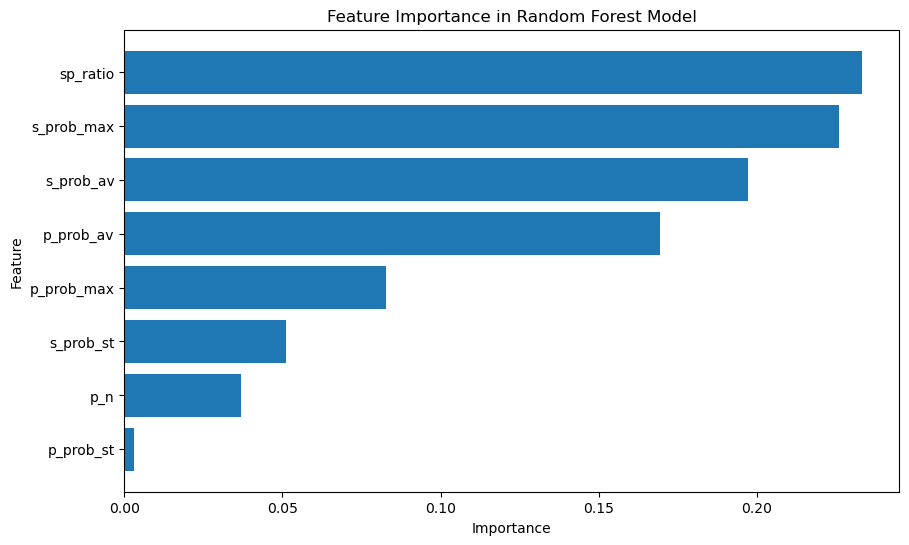

In [10]:
# Get feature importances from the model
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({'feature': features, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

# evaluate the model, get precision, recall, f1 score
y_pred = rf_model_pca.predict(X_test)
y_pred_proba = rf_model_pca.predict_proba(X_test)

from sklearn.metrics import precision_score, recall_score, f1_score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['feature'], feature_importance_df['importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Random Forest Model')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()

In [11]:
# Check PCA explained variance
explained_variance = pca.explained_variance_ratio_
print(f'Explained Variance by PCA components: {explained_variance}')
print(f'Total explained variance: {sum(explained_variance)}')

Explained Variance by PCA components: [0.74892037 0.08452669]
Total explained variance: 0.8334470603268904


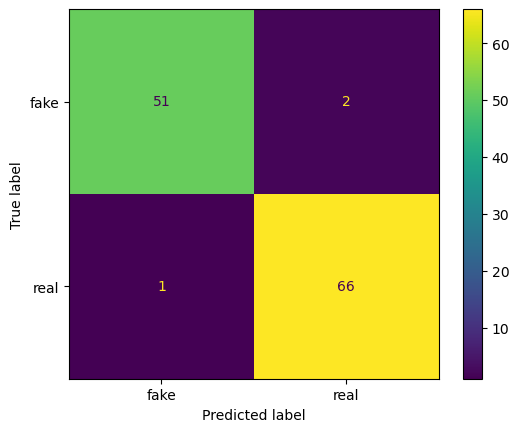

In [12]:
# print confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['fake', 'real'])
disp.plot()
plt.show()

In [13]:
import joblib

# Save the trained model to a file
joblib.dump(rf_model_pca, 'rf_model_pca.joblib')

# Save the scaler and PCA transformation
joblib.dump(scaler, 'scaler.joblib')
joblib.dump(pca, 'pca.joblib')

print("Model, scaler, and PCA transformer saved successfully.")


Model, scaler, and PCA transformer saved successfully.


## Random Forest 2 variables

Precision: 1.00
Recall: 1.00
F1 Score: 1.00


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


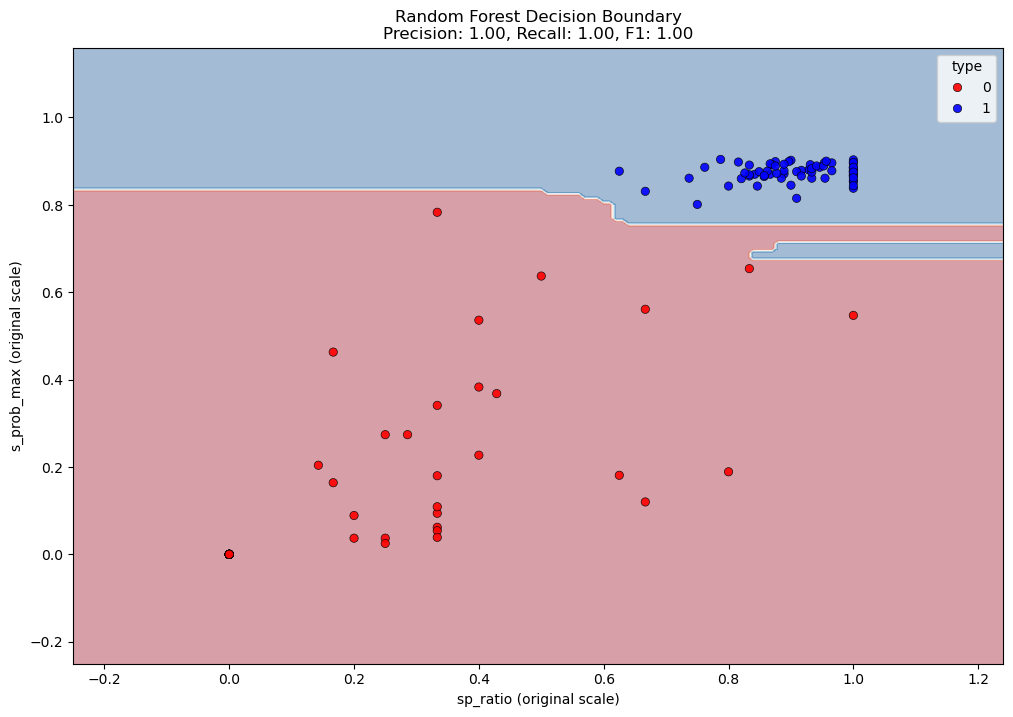

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score

# Load your dataset
# df = pd.read_csv('combined_output.csv')
df = pd.read_csv('combined_output_clean_test1.csv')
df.fillna(0, inplace=True)

# Specify features and target
features = ['sp_ratio', 's_prob_max']
X = df[features]
y = df['type']
event_ids = df['event_id']  # Assuming there's an 'event_id' column to track IDs

# Remove infinities and drop rows with NaN
X = X.replace([np.inf, -np.inf], np.nan).dropna()
y = y.loc[X.index]  # Keep y and event_ids in sync with X after dropping rows
event_ids = event_ids.loc[X.index]

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/Test split
X_train_scaled, X_test_scaled, y_train, y_test, event_ids_train, event_ids_test = train_test_split(
    X_scaled, y, event_ids, test_size=0.3, random_state=42
)

# Random Forest training
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Predict on test set
y_pred = rf_model.predict(X_test_scaled)
y_pred_proba = rf_model.predict_proba(X_test_scaled)  # Get probabilities

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

# Identify misclassified points
misclassified = (y_test != y_pred)
X_test_misclassified = X_test_scaled[misclassified]
event_ids_misclassified = event_ids_test[misclassified]
probs_misclassified = y_pred_proba[misclassified]

# Inverse-transform the test set to original coordinates for plotting
X_test_original = scaler.inverse_transform(X_test_scaled)

# Handle case with no misclassified points
if len(X_test_misclassified) > 0:
    X_test_misclassified_original = scaler.inverse_transform(X_test_misclassified)
else:
    X_test_misclassified_original = np.empty((0, 2))

# --------------------------
# Plot decision boundary
# --------------------------

# 1. Create meshgrid in ORIGINAL coordinates
x_min, x_max = X['sp_ratio'].min() - 0.25, X['sp_ratio'].max() + 0.25
y_min, y_max = X['s_prob_max'].min() - 0.25, X['s_prob_max'].max() + 0.25
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))

# 2. Scale the mesh points for prediction
grid_points = np.c_[xx.ravel(), yy.ravel()]
grid_points_scaled = scaler.transform(grid_points)
Z = rf_model.predict(grid_points_scaled)
Z = Z.reshape(xx.shape)

# Plot the decision boundary
plt.figure(figsize=(12,8))
plt.contourf(xx, yy, Z, alpha=0.4, cmap='RdBu')

# Scatterplot in original space
sns.scatterplot(
    x=X_test_original[:,0],
    y=X_test_original[:,1],
    hue=y_test,
    palette=['red','blue'],
    alpha=0.9,
    edgecolor='k'
)

# Annotate misclassified points with event IDs and probabilities (if any exist)
if len(X_test_misclassified_original) > 0:
    for idx, (x, y) in enumerate(X_test_misclassified_original):
        event_id = event_ids_misclassified.iloc[idx]
        prob_real = probs_misclassified[idx, 1]  # Probability of being "real"
        plt.text(
            x + 0.02, y + 0.02,
            f"ID: {event_id}\nP(real): {prob_real:.2f}",
            fontsize=9, color='black'
        )

plt.title(f'Random Forest Decision Boundary\nPrecision: {precision:.2f}, Recall: {recall:.2f}, F1: {f1:.2f}')
plt.xlabel('sp_ratio (original scale)')
plt.ylabel('s_prob_max (original scale)')
plt.show()


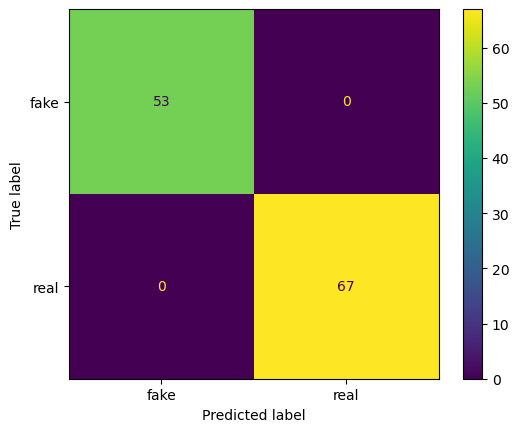

In [15]:
# print confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['fake', 'real'])
disp.plot()
plt.show()

# XGBoost

Precision: 0.99
Recall: 1.00
F1 Score: 0.99


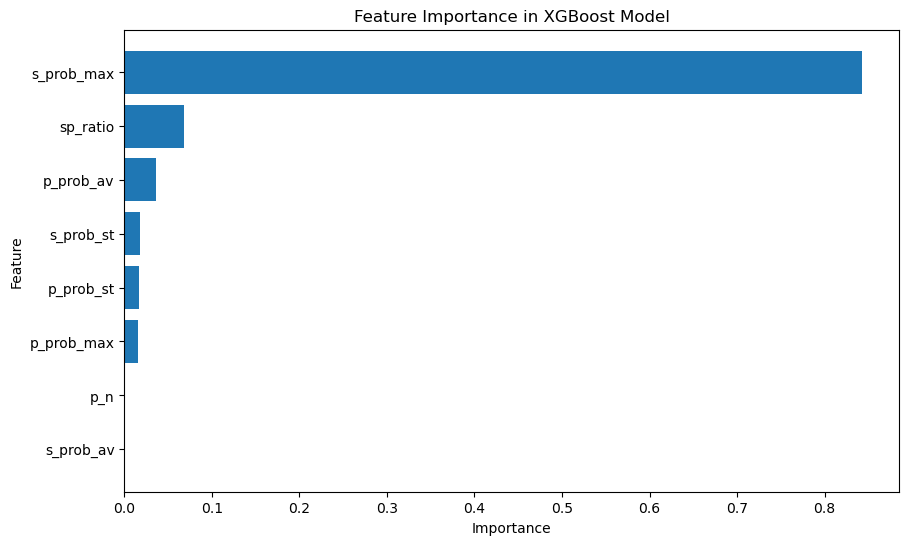

In [16]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import precision_score, recall_score, f1_score

# Load the combined dataset
# df = pd.read_csv('combined_output.csv')
df = pd.read_csv('combined_output_clean_test1.csv')
df.fillna(0, inplace=True)

# Specify the features and the target variable
features = ['p_n', 'sp_ratio', 'p_prob_av', 's_prob_av', 'p_prob_st', 
            's_prob_st', 'p_prob_max', 's_prob_max']
X = df[features]
y = df['type']
X = X.replace([np.inf, -np.inf], np.nan).dropna()
y = y.replace([np.inf, -np.inf], np.nan).dropna()

# Standardize the features for better performance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Initialize and train the XGBoost model
xgb_model = XGBClassifier(random_state=42, n_estimators=100)
xgb_model.fit(X_train, y_train)

# Get feature importances from the model
importances = xgb_model.feature_importances_
feature_importance_df = pd.DataFrame({'feature': features, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

# Evaluate the model, get precision, recall, f1 score
y_pred = xgb_model.predict(X_test)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['feature'], feature_importance_df['importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in XGBoost Model')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()


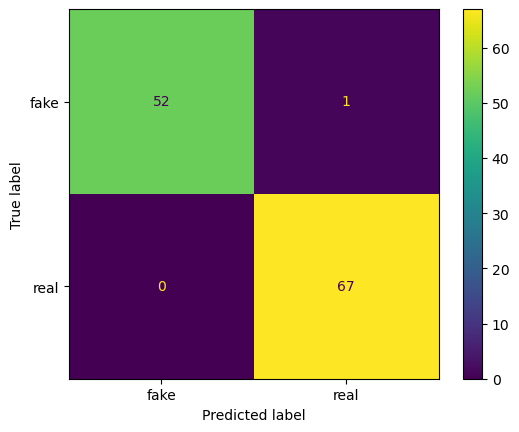

In [17]:
# print confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['fake', 'real'])
disp.plot()
plt.show()